In [92]:
using CSV, FileIO, DataFrames, Dates
using Plots, StatsPlots

In [93]:
region = "romania"
mkpath("./results/$region/")

"./results/romania"

In [114]:
df = CSV.read("./data/$region.csv", DataFrame);
first(df,5)

5×5 DataFrame
 Row │ Datetime             Latitude  Longitude  Depth    Magnitude 
     │ DateTime             Float64   Float64    Float64  Float64   
─────┼──────────────────────────────────────────────────────────────
   1 │ 0984-01-01T00:00:00      45.7       26.6    150.0        7.1
   2 │ 1022-05-12T00:00:00      45.7       26.6    150.0        6.5
   3 │ 1038-08-15T00:00:00      45.7       26.6    150.0        7.3
   4 │ 1091-01-01T00:00:00      45.7       26.6    150.0        7.1
   5 │ 1107-02-12T03:00:00      45.7       26.6    150.0        7.1

In [95]:
# Using describe function to get statistics of a dataset
describe(df)

5×7 DataFrame
 Row │ variable   mean     min                  median                   max   ⋯
     │ Symbol     Union…   Any                  Any                      Any   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Datetime            0984-01-01T00:00:00  2012-07-30T07:33:28.900  2022- ⋯
   2 │ Latitude   45.5928  43.5941              45.596                   48.23
   3 │ Longitude  25.5962  20.1                 26.4                     29.84
   4 │ Depth      38.5305  0.0                  11.7                     218.4
   5 │ Magnitude  2.36572  0.1                  2.2                      7.9   ⋯
                                                               3 columns omitted

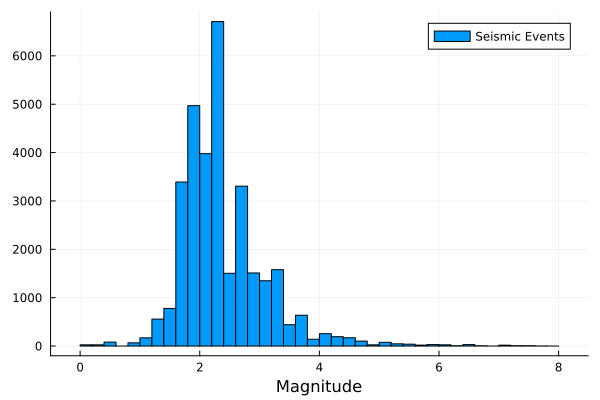

In [96]:
Plots.histogram(df[:,:Magnitude],
                bins = 40, xlabel = "Magnitude", label="Seismic Events")

In [97]:
function join_on_counted_no_mag_bounds(df,trim_year,magnitude_threshold)
	#######################################################
	# Get all counts for all years (no magnitude bounds)
	#######################################################

	# Trims the dataframe by year
	df_trimmed = df[(df.Datetime .> DateTime(trim_year,1,1,0,0,0)) .&
					(df.Magnitude .> magnitude_threshold),:]

	# Extracts just the year and puts it in the dataframe
	df_transformed = transform(df_trimmed, :Datetime => ByRow(year) => :Year)

	# Counts the number of occurences of each year resulting in number of events per year
	df_counted = combine(groupby(df_transformed, :Year), nrow => Symbol("count"));

	return df_counted
end
	

join_on_counted_no_mag_bounds (generic function with 1 method)

In [98]:
function join_on_counted(df,trim_year,minmag,maxmag)
	#######################################################
	# Get all counts for all years and magnitude thresholds
	#######################################################
	
	# Trims the dataframe by year and magnitude threshold
	df_trimmed_mag = df[(df.Datetime .> DateTime(trim_year,1,1,0,0,0)) .& 
						  (df.Magnitude .>= minmag) .&
						  (df.Magnitude .< maxmag),:]
	
	# Extracts just the year and puts it in the dataframe
	df_transformed_mag = transform(df_trimmed_mag, :Datetime => ByRow(year) => :Year)

	# Counts the number of occurences of each year resulting in number of events per year per magnitude
	df_counted_mag = combine(groupby(df_transformed_mag, :Year), nrow => Symbol("count_mag_$minmag"));

	# return outerjoin(df_counted, df_counted_mag, on= :Year)
	return df_counted_mag
end

join_on_counted (generic function with 1 method)

In [99]:
trim_year = 1800
magnitude_threshold = 0.0;

In [100]:
df_counted = join_on_counted_no_mag_bounds(df,trim_year,magnitude_threshold);

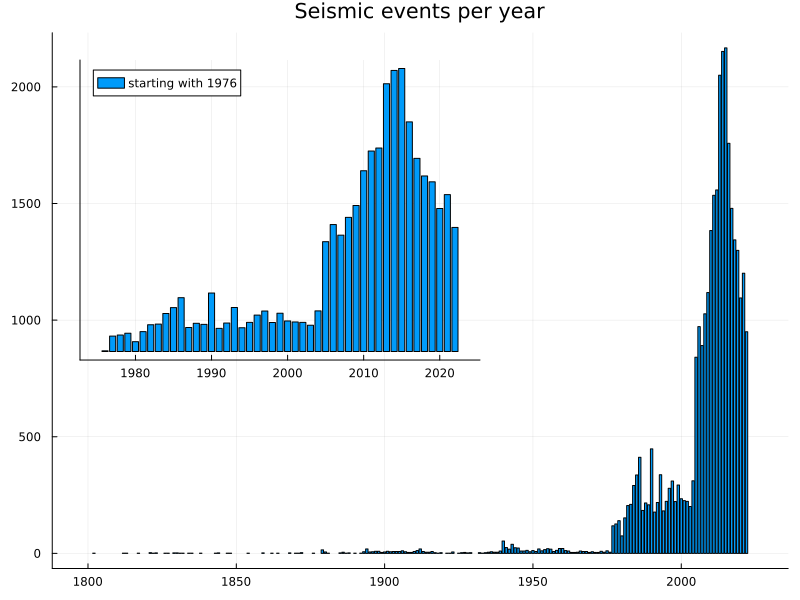

In [101]:
fig = bar(df_counted.Year, df_counted.count, 
	orientation=:vertical, 
	title="Seismic events per year",
    legend=false)
	# label="Seismic Events")
StatsPlots.plot!(size=(800,600))

# Inset plot
# Select from 1976 onwards 
bar!(df_counted.Year[end-46:end], df_counted.count[end-46:end], 
	orientation=:vertical,
    inset = bbox(0.1, 0.1, 0.5, 0.5, :top, :left), 
    label="starting with 1976",
    # ticks = nothing,
    yticks = nothing,
    subplot = 2,
    bg_inside = nothing)
	# label="Seismic Events")


savefig("./results/$region/events_per_year.png")
fig

In [102]:
trim_year = 1977
magnitude_threshold = 0.0;

In [103]:
df_counted = join_on_counted_no_mag_bounds(df,trim_year,magnitude_threshold);

In [104]:
for minmag=Int(floor(minimum(df.Magnitude))):Int(floor(maximum(df.Magnitude)))
	maxmag=minmag+1
	df_counted_mag_extra = join_on_counted(df,trim_year,minmag,maxmag)

	leftjoin!(df_counted, df_counted_mag_extra, on=:Year,makeunique=true)
	df_counted[!,Symbol("count_mag_$minmag")] = replace(df_counted[!,Symbol("count_mag_$minmag")], missing => 0)
end

In [105]:
df_counted

46×10 DataFrame
 Row │ Year   count  count_mag_0  count_mag_1  count_mag_2  count_mag_3  count ⋯
     │ Int64  Int64  Int64        Int64        Int64        Int64        Int64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  1977    118            6           14           57           34        ⋯
   2 │  1978    126            0            8           56           48
   3 │  1979    140            1            7           60           61
   4 │  1980     75            0            0           27           44
   5 │  1981    152            9           23           74           39        ⋯
   6 │  1982    205            2           18          125           51
   7 │  1983    210            5           55           84           55
   8 │  1984    291           32           62          136           51
  ⋮  │   ⋮      ⋮         ⋮            ⋮            ⋮            ⋮             ⋱
  40 │  2016   1758            0         1248          391          113        ⋯
  41 │  2017   1479            0         1017          357           99
  42 │  2018   1344            0          912          345           84
  43 │  2019   1299            0          912          284          101
  44 │  2020   1095            0          667          311          113        ⋯
  45 │  2021   1201            0          732          362          103
  46 │  2022    950            0          590          261           95
                                                   4 columns and 31 rows omitted

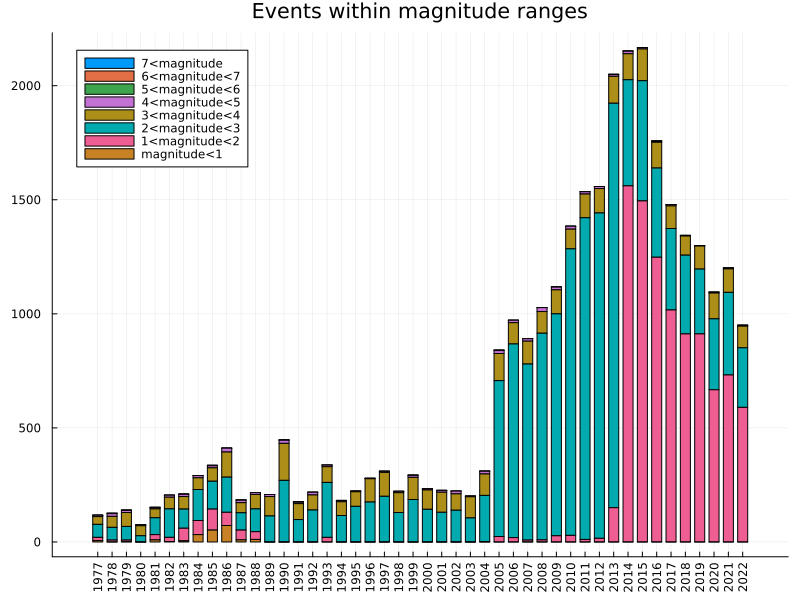

In [106]:

mags=[]
for minmag=0:7
	push!(mags,df_counted[!,Symbol("count_mag_$minmag")])
end

ticklabels = string.(collect(minimum(df_counted.Year):maximum(df_counted.Year)))

fig = groupedbar([ mags[8] mags[7] mags[6] mags[5] mags[4] mags[3] mags[2] mags[1] ],
			bar_position = :stack,
			bar_width=0.7,
			xticks=(1:46, ticklabels),
			xrotation=90,
			title="Events within magnitude ranges",
			label=["7<magnitude" "6<magnitude<7" "5<magnitude<6" "4<magnitude<5" "3<magnitude<4" "2<magnitude<3" "1<magnitude<2" "magnitude<1"])

StatsPlots.plot!(size=(800,600))

savefig("./results/$region/events_per_year_mags.png")
fig


In [107]:
# Test to check if all quakes have been properly placed in magnitude bracket 
quakes=0
for minmag=0:7
	quakes+= sum(df_counted[!,Symbol("count_mag_$minmag")])
end
quakes == sum(df_counted[!,:count])

true

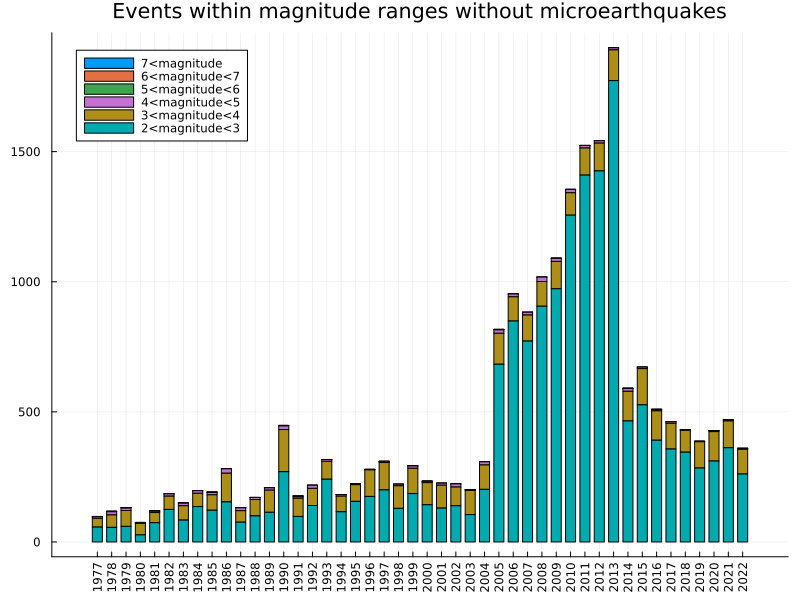

In [108]:

fig = groupedbar([ mags[8] mags[7] mags[6] mags[5] mags[4] mags[3]],
				bar_position = :stack,
				bar_width=0.7,
				xticks=(1:46, ticklabels),
				xrotation=90,
				title="Events within magnitude ranges without microearthquakes",
				label=["7<magnitude" "6<magnitude<7" "5<magnitude<6" "4<magnitude<5" "3<magnitude<4" "2<magnitude<3" ]
				)

StatsPlots.plot!(size=(800,600))

savefig("./results/$region/events_per_year_mags_no_microearthquakes.png")
fig


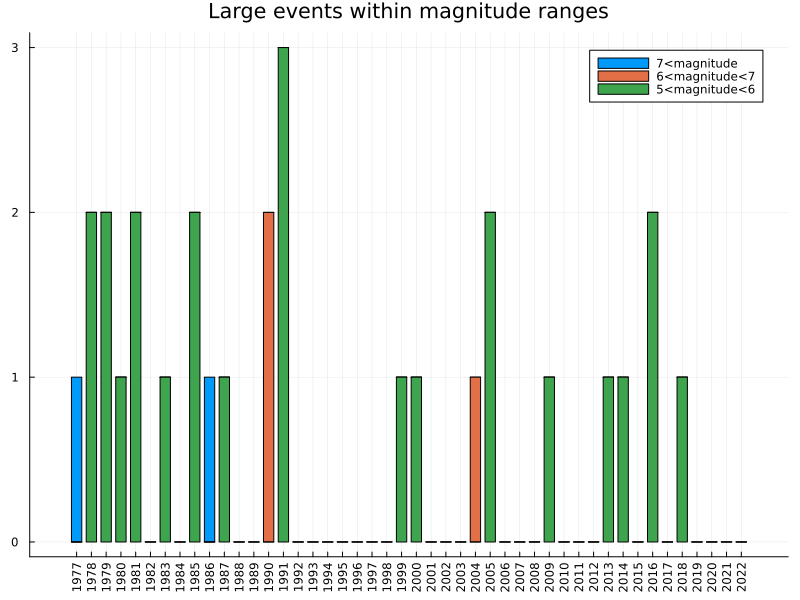

In [109]:
fig = groupedbar([ mags[8] mags[7] mags[6]],
				bar_position = :stack,
				bar_width=0.7,
				xticks=(1:46, ticklabels),
				xrotation=90,
				title="Large events within magnitude ranges",
				label=["7<magnitude" "6<magnitude<7" "5<magnitude<6"]
				)

StatsPlots.plot!(size=(800,600))

savefig("./results/$region/events_per_year_mags_large.png")
fig

In [115]:
using GLMakie, CairoMakie

In [182]:
# Theme
seismic_theme = Theme(
    # fontsize = 24,
    Axis3 = (
        xlabelsize = 24,
        xlabeloffset = 40,
        xticklabelsize  = 16,

        ylabelsize = 24,
        ylabeloffset = 40,
        yticklabelsize  = 16,

        zlabelsize = 24,
        zlabeloffset = 60,
        zticklabelsize  = 16
        )
                    );

In [177]:
function seismic_scatter_2D(region, trim_year, magnitude_threshold, with_image, img=nothing)
	
	CairoMakie.activate!()
	
	mapcoords= Dict("minLat"=>minimum(region.Latitude),
		            "maxLat"=>maximum(region.Latitude),
		            "minLon"=>minimum(region.Longitude),
		            "maxLon"=>maximum(region.Longitude),
					)
	
	region = region[(region.Datetime .> DateTime(trim_year,1,1,0,0,0)) .&
					(region.Magnitude .> magnitude_threshold),:]

	fig = Figure( resolution=(1080, 720))
	ax = Axis(fig[1,1];    
	    title = L"\text{Seismic Events in region}", titlesize = 40,
	    xlabel = "Longitude", ylabel = "Latitude",
	)

	markerSizes = [1.7^x for x in region.Magnitude];

	limits!(mapcoords["minLon"], mapcoords["maxLon"], mapcoords["minLat"], mapcoords["maxLat"])
	
	if with_image == true
		# img_path = "./maps/romania_wikipedia.png"
		# img = load(img_path);
		CairoMakie.image!( 
				range(mapcoords["minLon"],mapcoords["maxLon"],step=0.01),
				range(mapcoords["minLat"],mapcoords["maxLat"],step=0.01),
			    rotr90(img*0.55);
				)
	end

	sc = CairoMakie.scatter!(ax, region.Longitude, region.Latitude,
	    markersize= markerSizes,
		markeralpha = region.Depth,
	    color= region.Magnitude,
	    colormap= (Reverse(:devon), 1),
	    strokewidth= 0.5,
	    shading= false
	)

	Colorbar(fig[1, 2], sc, label="Magnitude", height=Relative(0.85))

	return fig
end

seismic_scatter_2D (generic function with 2 methods)

In [189]:
function seismic_scatter_3D(region, trim_year, magnitude_threshold, with_image, img=nothing)
	GLMakie.activate!()
	set_theme!(seismic_theme)
	
	mapcoords= Dict("minLat"=>minimum(region.Latitude),
		            "maxLat"=>maximum(region.Latitude),
		            "minLon"=>minimum(region.Longitude),
		            "maxLon"=>maximum(region.Longitude),
		            "minDepth"=>minimum(region.Depth),
		            "maxDepth"=>maximum(region.Depth),
					)
	
	region = region[(region.Datetime .> DateTime(trim_year,1,1,0,0,0)) .&
					(region.Magnitude .> magnitude_threshold),:]

	mapcoords["maxDepth"]=maximum(region.Depth)

	fig = Figure( resolution=(1080, 720))

	# scene = Scene(resolution = (600, 400))
	# scale!(scene, 1, 2, 2)

	# lscene = LScene(fig[1, 1])
	# # surface!(lscene, ...)
	
	# cam = cameracontrols(lscene.scene)
	# cam.lookat[] = [0, 0, 200]
	# cam.eyeposition[] = [3000, 200, 2000]
	# update_cam!(lscene.scene, cam)

	# parent = Scene(backgroundcolor=:white)
	# cam3d!(parent)

	# camc = cameracontrols(parent)
	# update_cam!(parent, camc, Vec3f(0, 0, 0), Vec3f(4.0, 0, 0))
	
	# cam = Makie.camera(scene)
	
	ax = Axis3(fig[1,1];    
	    title = L"\text{Seismic Events in region}", titlesize = 40,
	    xlabel = "Longitude", ylabel = "Latitude", zlabel = "Depth",
		# viewmode = :fit,
	    perspectiveness=0.5,
		aspect=(1.3, 1, 0.5)
	)
	# scale!(ax.scene,1.0,1.0,0.7)
	
	markerSizes = [1.7^x for x in region.Magnitude];
	
	sc = GLMakie.scatter!(ax, region.Longitude, region.Latitude, -region.Depth;
		markersize= markerSizes,
		color= region.Magnitude,
		colormap= (Reverse(:devon), 0.99),
		strokewidth= 0.5,
		shading= false,
	)

	Colorbar(fig[1, 2], sc, label="Magnitude", height=Relative(0.85))
	if with_image == true
		# img_path = "./maps/romania_wikipedia.png"
		# img = load(img_path);
		image!(ax , 
				mapcoords["minLon"] .. mapcoords["maxLon"],
				mapcoords["minLat"] .. mapcoords["maxLat"],

				# range(mapcoords["minLon"],mapcoords["maxLon"],step=0.01),
				# range(mapcoords["minLat"],mapcoords["maxLat"],step=0.01),
			    rotr90(img*0.7); 
			    transformation=(:xy,10)# -mapcoords["maxDepth"]),
				)
	end

    return fig
end

seismic_scatter_3D (generic function with 2 methods)

In [179]:
img_path = "./maps/romania_wikipedia.png"
img = load(img_path);

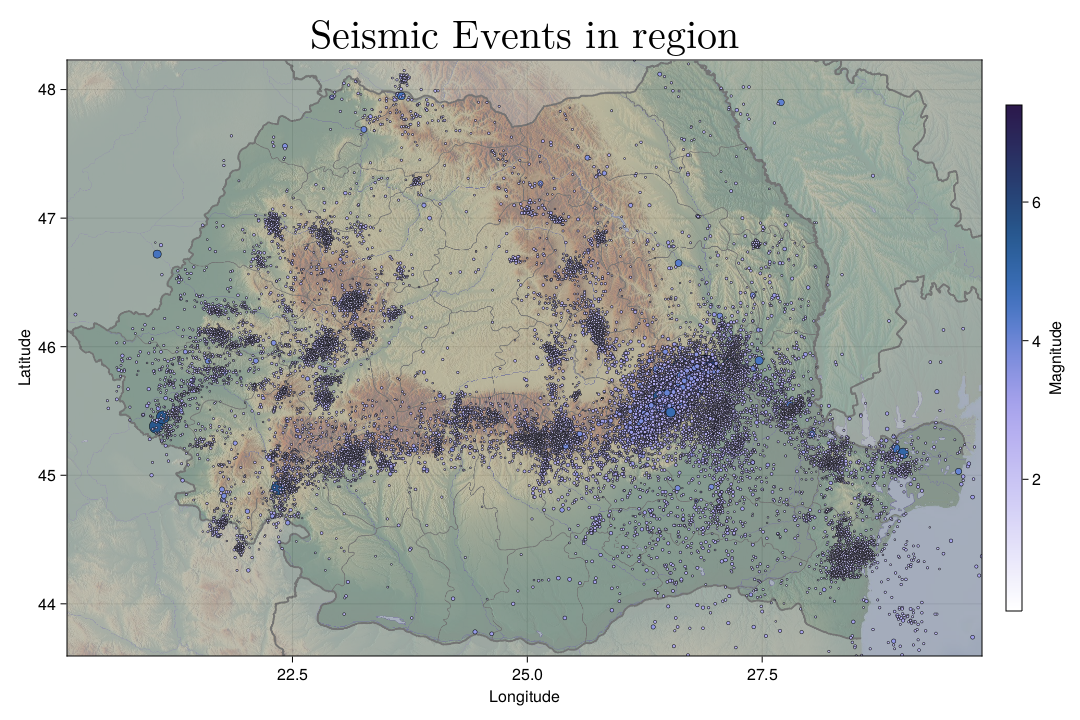

In [180]:
fig = seismic_scatter_2D(df, trim_year, magnitude_threshold, true, img)
save("./results/$region/2D_mag_$magnitude_threshold.png", fig)
fig

In [190]:
fig = seismic_scatter_3D(df, trim_year, magnitude_threshold, true, img)
save("./results/$region/3D_mag_$magnitude_threshold.png", fig)
fig

## Vrancea

In [196]:
vrancea = df[(df.Longitude .>= 26 ) .& (df.Longitude .<= 27) .&
				  (df.Latitude .>= 45.2) .& (df.Latitude .<= 46) .&# ,:]
				  (df.Depth .>= 50) .& (df.Depth .<= 200) ,:];

vrancea = vrancea[(vrancea.Datetime .> DateTime(trim_year,1,1,0,0,0)) .&
					(vrancea.Magnitude .> magnitude_threshold),:]

first(vrancea,5)

5×5 DataFrame
 Row │ Datetime                 Latitude  Longitude  Depth    Magnitude 
     │ DateTime                 Float64   Float64    Float64  Float64   
─────┼──────────────────────────────────────────────────────────────────
   1 │ 1977-03-04T19:21:54.100     45.77      26.76     94.0        7.4
   2 │ 1977-03-04T21:21:01.100     45.22      26.65    141.0        3.0
   3 │ 1977-03-05T02:35:22         45.63      26.19    121.3        3.0
   4 │ 1977-03-05T12:08:42         45.37      26.3     124.0        3.5
   5 │ 1977-03-06T13:27:06.300     45.83      26.63    112.3        2.6

In [197]:
describe(vrancea)

5×7 DataFrame
 Row │ variable   mean     min                      median                   m ⋯
     │ Symbol     Union…   Any                      Any                      A ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Datetime            1977-03-04T19:21:54.100  2007-01-22T20:33:44.100  2 ⋯
   2 │ Latitude   45.638   45.2                     45.65                    4
   3 │ Longitude  26.5659  26.0                     26.58                    2
   4 │ Depth      115.671  50.0                     120.6                    1
   5 │ Magnitude  3.04875  0.6                      3.0                      7 ⋯
                                                               3 columns omitted

In [198]:
img_path = "./maps/vrancea_wikipedia.png"
img = load(img_path);

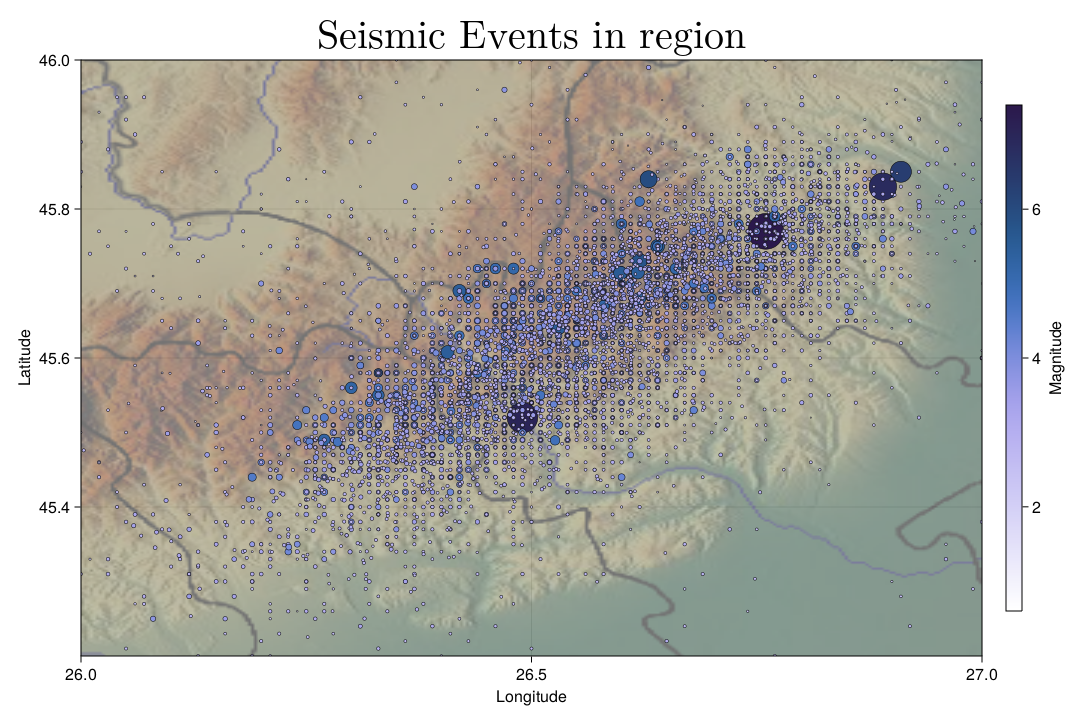

In [199]:
fig = seismic_scatter_2D(vrancea, trim_year, magnitude_threshold, true, img)
save("./results/$region/vrancea_2D_mag_$magnitude_threshold.png", fig)
fig

In [205]:
function seismic_scatter_3D_vrancea(region, trim_year, magnitude_threshold, with_image, img=nothing)
	GLMakie.activate!()
	set_theme!(seismic_theme)
	
	mapcoords= Dict("minLat"=>minimum(region.Latitude),
		            "maxLat"=>maximum(region.Latitude),
		            "minLon"=>minimum(region.Longitude),
		            "maxLon"=>maximum(region.Longitude),
		            "minDepth"=>minimum(region.Depth),
		            "maxDepth"=>maximum(region.Depth),
					)
	
	region = region[(region.Datetime .> DateTime(trim_year,1,1,0,0,0)) .&
					(region.Magnitude .> magnitude_threshold),:]

	mapcoords["maxDepth"]=maximum(region.Depth)

	fig = Figure( resolution=(1080, 720))

	ax = Axis3(fig[1,1];    
	    title = L"\text{Seismic Events in region}", titlesize = 40,
	    xlabel = "Longitude", ylabel = "Latitude", zlabel = "Depth",
		# viewmode = :fit,
	    perspectiveness=0.5,
		aspect=(1.3, 1, 2)
	)
	# scale!(ax.scene,1.0,1.0,0.7)
	
	markerSizes = [1.7^x for x in region.Magnitude];
	
	sc = GLMakie.scatter!(ax, region.Longitude, region.Latitude, -region.Depth;
		markersize= markerSizes,
		color= region.Magnitude,
		colormap= (Reverse(:devon), 0.99),
		strokewidth= 0.5,
		shading= false,
	)

	Colorbar(fig[1, 2], sc, label="Magnitude", height=Relative(0.85))
	if with_image == true
		# img_path = "./maps/romania_wikipedia.png"
		# img = load(img_path);
		image!(ax , 
				mapcoords["minLon"] .. mapcoords["maxLon"],
				mapcoords["minLat"] .. mapcoords["maxLat"],

				# range(mapcoords["minLon"],mapcoords["maxLon"],step=0.01),
				# range(mapcoords["minLat"],mapcoords["maxLat"],step=0.01),
			    rotr90(img*0.7); 
			    transformation=(:xy,10)# -mapcoords["maxDepth"]),
				)
	end

    return fig
end

seismic_scatter_3D_vrancea (generic function with 2 methods)

In [206]:
fig = seismic_scatter_3D_vrancea(vrancea, trim_year, magnitude_threshold, true, img)
save("./results/$region/vrancea_3D_mag_$magnitude_threshold.png", fig)
fig